# Rupaul's Drag Race Machine

In [33]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import pandas as pd
import numpy as np
import math, random
from scipy.stats import rankdata, kendalltau
from sklearn.preprocessing import scale

theData = pd.read_csv("dragrace9.csv")
theData= theData.fillna(0)

In [4]:
queens = theData.groupby('Name').max()
queens = queens.reset_index(drop=False)
#queens.iloc[1:10,:]

In [5]:
# create a function to scale the data for us
def scaleQueens(df):
    """Scale Age, Wins, Highs, Lows, and Lipsyncs in feature data frames"""
    df = df.copy(deep=True)
    df['Age'] = scale(df['Age'])
    df['Wins'] = scale(df['Wins'])
    df['Highs'] = scale(df['Highs'])
    df['Lows'] = scale(df['Lows'])
    df['Lipsyncs'] = scale(df['Lipsyncs'])
    df['Season'] = df['Season']/8
    return df

In [6]:
def compareRanks(x,y):
    x=np.asarray(x)
    y=np.asarray(y)
    numRanks = np.append(x,y).max()
    actual=np.sum(np.square(x-y))
    worst=np.sum(np.square(np.sort(x)-np.sort(x)[::-1]))
    return 1-2*(actual/worst)

In [7]:
def createPD(s,queens,yfitpd):
    season = queens.loc[queens.Season==s,['Name','Place']]
    seasonpred = yfitpd.loc[queens.Season==s]
    season['Predicted'] = seasonpred
    season['Predicted'] = rankdata(season.Predicted,method='min')
    season = season.sort_values('Place')
    return season

In [14]:
def predictSeason(season,model,queens,scaled=False):
    Xtrain = queens.loc[queens.Season!=season,['Age','PuertoRico','PlusSize','Wins','Highs','Lows','Lipsyncs','Season']]
    Xtest = queens.loc[queens.Season==season,['Age','PuertoRico','PlusSize','Wins','Highs','Lows','Lipsyncs','Season']]
    ytrain = queens.loc[queens.Season!=season,'Place']
    if scaled:
        Xtrain = scaleQueens(Xtrain)
        Xtest = scaleQueens(Xtest)
    model.fit(Xtrain,ytrain)
    yfit = model.predict(Xtest)
    pddf = queens.loc[queens.Season==season,['Name','Place']]
    pddf['Predicted'] = rankdata(yfit,method='min')
    return pddf

In [36]:
def setXY(x,y,n):
    """Get appropriate x,y coords in cases of ties"""
    y = y - int((n-1)/3)*0.8
    if n % 3 == 2:
        x = x - 0.33
    elif n % 3 == 0:
        x = x + 0.33
    return(x,y)

# Predict All Stars

In [9]:
# create series with names of all star queens
allstars = pd.Series(['Aja','BenDeLaCreme',"Chi Chi DeVayne","Kennedy Davenport",
                     "Milk","Morgan McMichaels","Shangela-3","Thorgy Thor","Trixie Mattel"])
allstars

0                  Aja
1         BenDeLaCreme
2      Chi Chi DeVayne
3    Kennedy Davenport
4                 Milk
5    Morgan McMichaels
6           Shangela-3
7          Thorgy Thor
8        Trixie Mattel
dtype: object

In [10]:
names = queens.Name
mask = names.isin(allstars)
Xtest = queens.loc[mask,['Age','PuertoRico','PlusSize','Wins','Highs','Lows','Lipsyncs','Season']]
ytest = queens.loc[mask,'Place']

Xtrain = queens.loc[~mask,['Age','PuertoRico','PlusSize','Wins','Highs','Lows','Lipsyncs','Season']]
ytrain = queens.loc[~mask,'Place']

In [11]:
AllStars = queens.loc[mask,['Name','Season','Place']]
AllStars

,Name,Season,Place
2,Aja,9,9
11,BenDeLaCreme,6,5
17,Chi Chi DeVayne,8,4
47,Kennedy Davenport,7,4
62,Milk,6,9
66,Morgan McMichaels,2,8
91,Shangela-3,3,6
101,Thorgy Thor,8,6
104,Trixie Mattel,7,6


In [12]:
XtrainS = scaleQueens(Xtrain)
XtestS = scaleQueens(Xtest)

/Users/telliott27/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [13]:
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPClassifier

svc_model = SVC(kernel='rbf',gamma=0.01,C=10)
gnb_model = GaussianNB()
rfc_model = RandomForestClassifier(n_estimators=100, random_state=0)
rfr_model = RandomForestRegressor(200,random_state=24601)
nn2_model=MLPClassifier(hidden_layer_sizes=(5,),
                       activation='logistic',
                       solver='lbfgs',
                       random_state=24601)

In [15]:
predictSeason(9,nn2_model,queens,True)

/Users/telliott27/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


,Name,Place,Predicted
2,Aja,9,9
6,Alexis Michelle,5,6
16,Charlie Hides,12,12
20,Cynthia Lee Fontaine,10,13
27,Eureka,11,10
28,Farrah Moan,8,7
38,Jaymes Mansfield,14,10
50,Kimora Blac,13,13
72,Nina Bo'Nina Brown,6,4
78,Peppermint,2,4


# Support Vector Classifier

In [16]:
svc_model.fit(XtrainS,ytrain)
yfit = svc_model.predict(XtestS)
AllStars['SVC'] = rankdata(yfit,method='min')
AllStars

,Name,Season,Place,SVC
2,Aja,9,9,6
11,BenDeLaCreme,6,5,1
17,Chi Chi DeVayne,8,4,4
47,Kennedy Davenport,7,4,1
62,Milk,6,9,6
66,Morgan McMichaels,2,8,6
91,Shangela-3,3,6,3
101,Thorgy Thor,8,6,6
104,Trixie Mattel,7,6,5


# Gaussian Naive Bayes

In [17]:
gnb_model.fit(Xtrain,ytrain)
yfit = gnb_model.predict(Xtest)
AllStars['GNB'] = rankdata(yfit,method='min')
AllStars

,Name,Season,Place,SVC,GNB
2,Aja,9,9,6,8
11,BenDeLaCreme,6,5,1,1
17,Chi Chi DeVayne,8,4,4,4
47,Kennedy Davenport,7,4,1,1
62,Milk,6,9,6,8
66,Morgan McMichaels,2,8,6,4
91,Shangela-3,3,6,3,3
101,Thorgy Thor,8,6,6,4
104,Trixie Mattel,7,6,5,4


# Random Forest Classifier

In [18]:
rfc_model.fit(Xtrain,ytrain)
yfit = rfc_model.predict(Xtest)
AllStars['RFC'] = rankdata(yfit,method='min')
AllStars

,Name,Season,Place,SVC,GNB,RFC
2,Aja,9,9,6,8,8
11,BenDeLaCreme,6,5,1,1,1
17,Chi Chi DeVayne,8,4,4,4,2
47,Kennedy Davenport,7,4,1,1,4
62,Milk,6,9,6,8,8
66,Morgan McMichaels,2,8,6,4,5
91,Shangela-3,3,6,3,3,3
101,Thorgy Thor,8,6,6,4,5
104,Trixie Mattel,7,6,5,4,7


# Random Forest Regressor

In [19]:
rfr_model.fit(Xtrain,ytrain)
yfit = rfr_model.predict(Xtest)
AllStars['RFR'] = rankdata(yfit,method='min')
AllStars

,Name,Season,Place,SVC,GNB,RFC,RFR
2,Aja,9,9,6,8,8,9
11,BenDeLaCreme,6,5,1,1,1,2
17,Chi Chi DeVayne,8,4,4,4,2,4
47,Kennedy Davenport,7,4,1,1,4,3
62,Milk,6,9,6,8,8,8
66,Morgan McMichaels,2,8,6,4,5,5
91,Shangela-3,3,6,3,3,3,1
101,Thorgy Thor,8,6,6,4,5,7
104,Trixie Mattel,7,6,5,4,7,6


# Neural Network

In [20]:
nn2_model.fit(XtrainS,ytrain)
yfit = nn2_model.predict(XtestS)
AllStars['NN'] = rankdata(yfit,method='min')
AllStars

,Name,Season,Place,SVC,GNB,RFC,RFR,NN
2,Aja,9,9,6,8,8,9,5
11,BenDeLaCreme,6,5,1,1,1,2,1
17,Chi Chi DeVayne,8,4,4,4,2,4,4
47,Kennedy Davenport,7,4,1,1,4,3,3
62,Milk,6,9,6,8,8,8,5
66,Morgan McMichaels,2,8,6,4,5,5,5
91,Shangela-3,3,6,3,3,3,1,1
101,Thorgy Thor,8,6,6,4,5,7,9
104,Trixie Mattel,7,6,5,4,7,6,5


In [32]:
AllStars.to_csv('AllStars.csv')

In [31]:
AllStars['mean'] = AllStars[['SVC','GNB','RFC','RFR','NN']].mean(axis=1)
AllStars['PredPlace'] = rankdata(AllStars['mean'],method='min')
AllStars.sort_values(by='mean')

,Name,Season,Place,SVC,GNB,RFC,RFR,NN,mean,PredPlace
11,BenDeLaCreme,6,5,1,1,1,2,1,1.2,1
91,Shangela-3,3,6,3,3,3,1,1,2.2,2
47,Kennedy Davenport,7,4,1,1,4,3,3,2.4,3
17,Chi Chi DeVayne,8,4,4,4,2,4,4,3.6,4
66,Morgan McMichaels,2,8,6,4,5,5,5,5.0,5
104,Trixie Mattel,7,6,5,4,7,6,5,5.4,6
101,Thorgy Thor,8,6,6,4,5,7,9,6.2,7
62,Milk,6,9,6,8,8,8,5,7.0,8
2,Aja,9,9,6,8,8,9,5,7.2,9


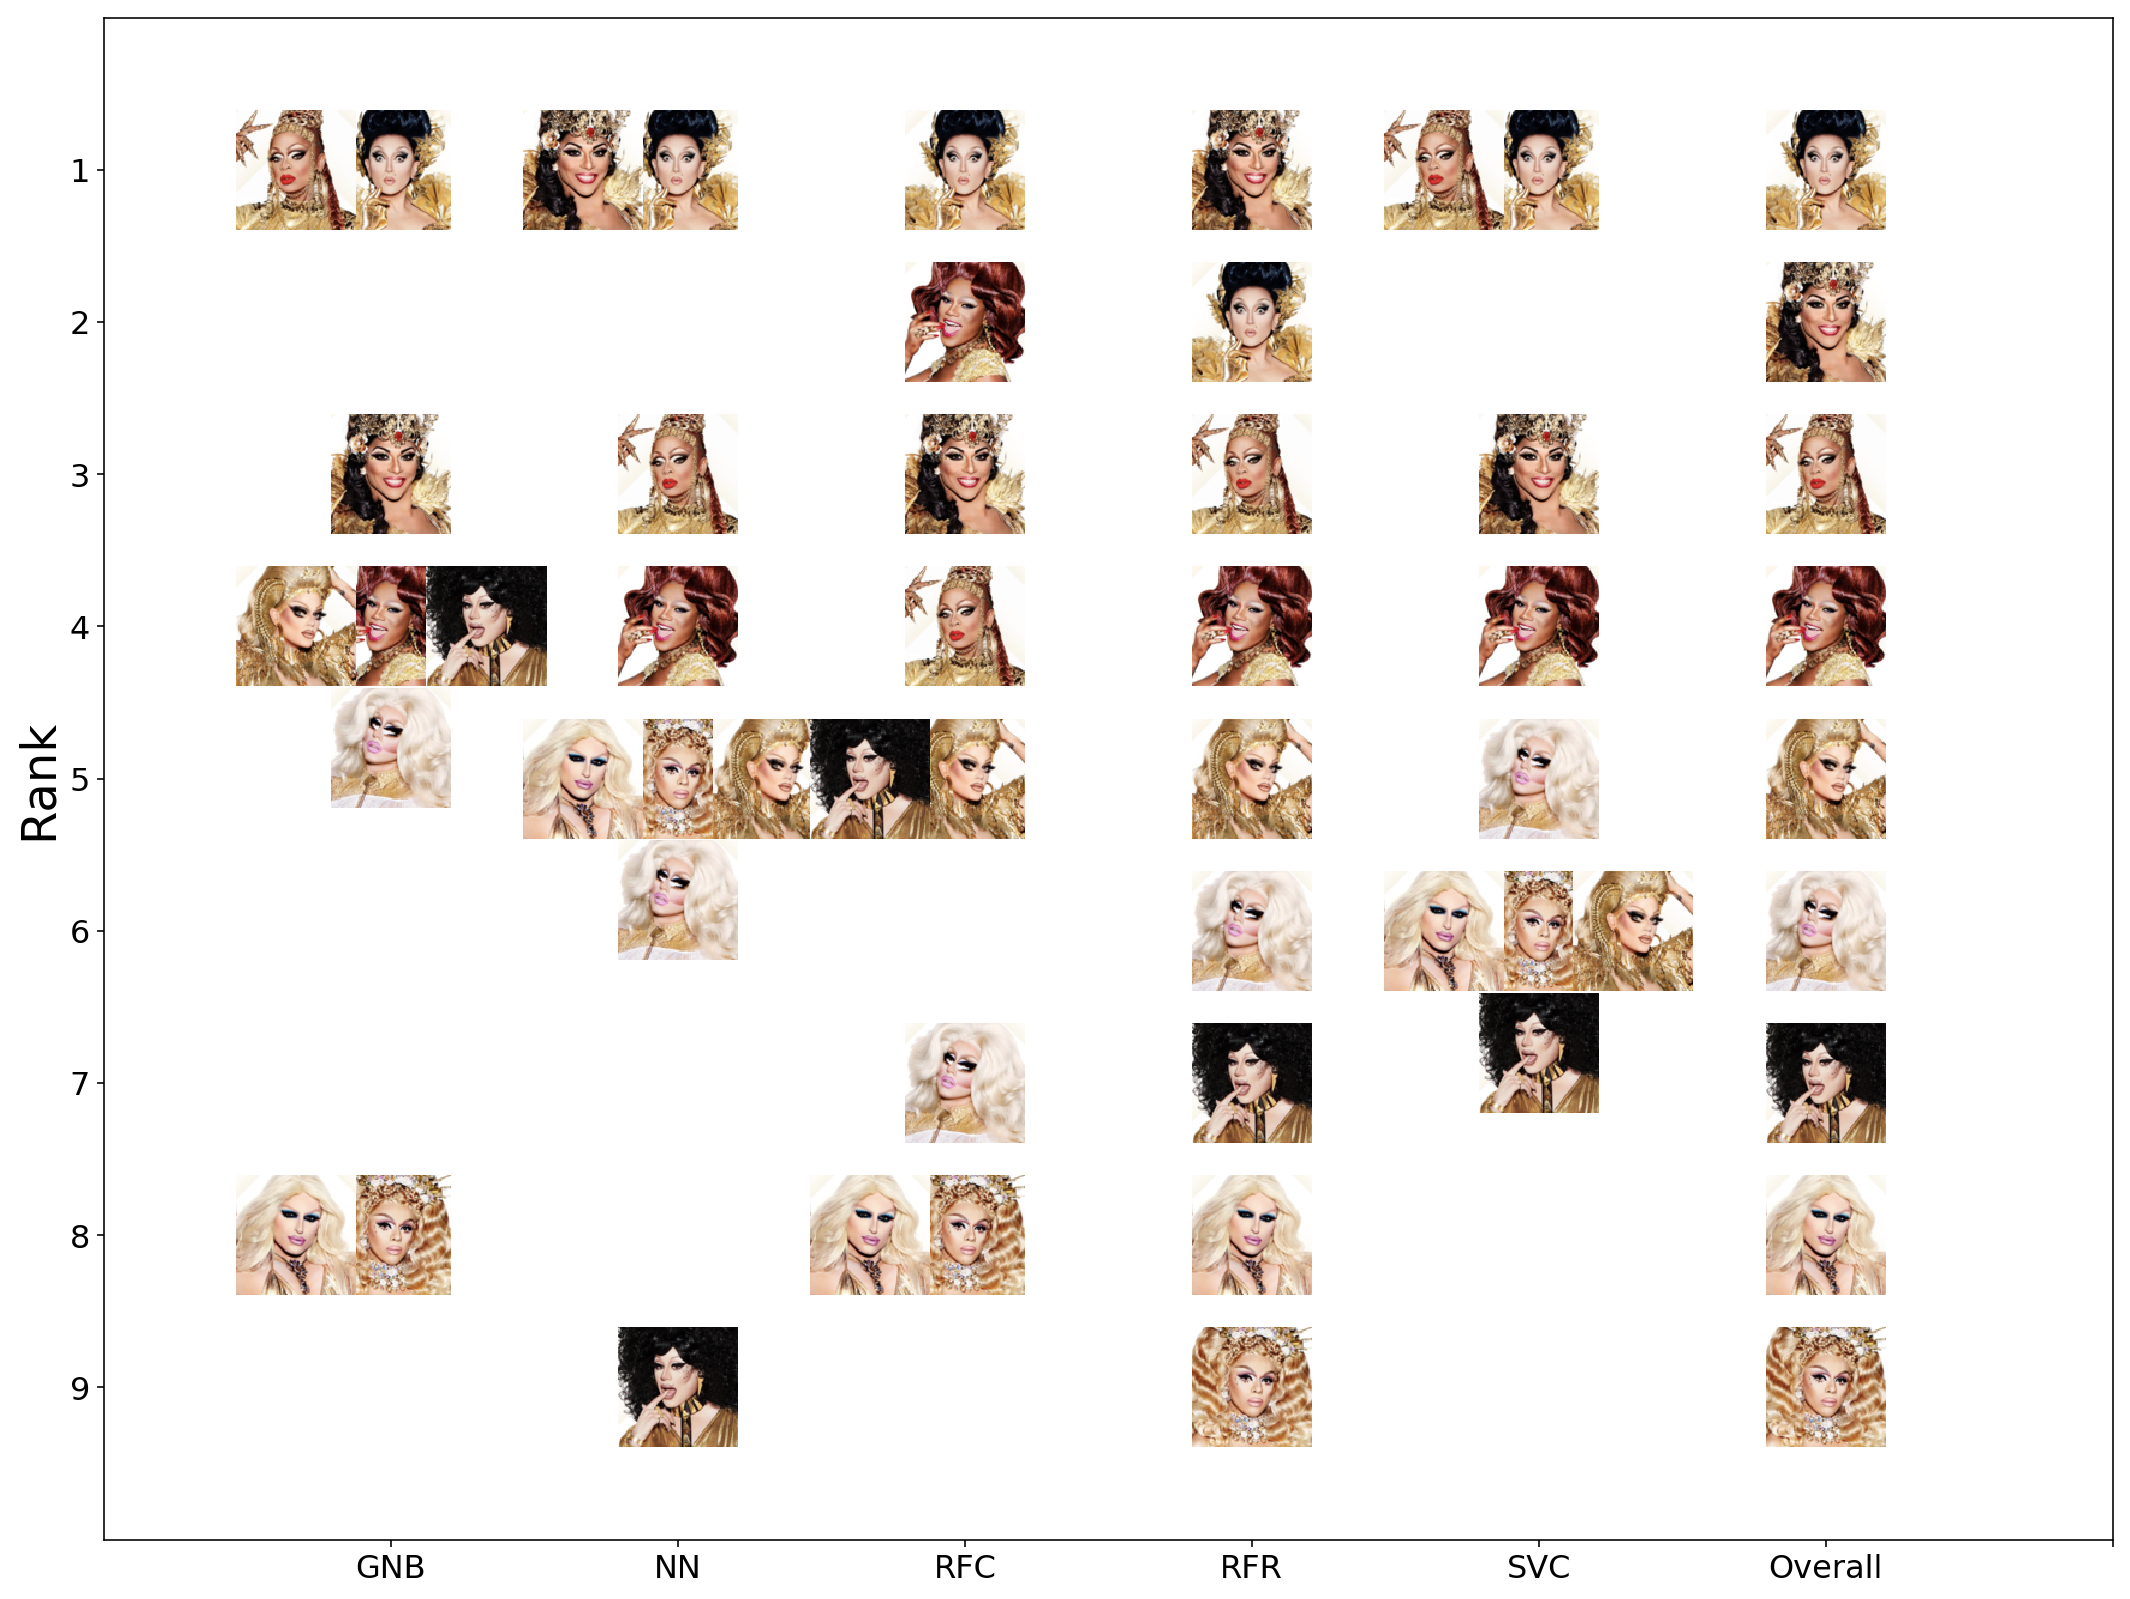

In [42]:
num_queens = 9

fig = plt.figure(figsize=(18,14))
ax = fig.add_subplot(1,1,1)
plt.xticks(range(7), ['GNB','NN','RFC','RFR','SVC','Overall'], size='small')
plt.yticks(range(num_queens),range(num_queens,0,-1))
ax.set_ylim([-1,num_queens])
ax.set_xlim([-1,6])
ax.set_ylabel("Rank",fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=16)

models = ['GNB','NN','RFC','RFR','SVC']

for i in range(5):
    the_data = AllStars
    places = {}
    for name in the_data.Name:
        file_name = name.replace(" ","").replace("'","") + "As3Mug.png"
        place = num_queens-np.asscalar(the_data.loc[the_data.Name==name,models[i]])
        if place in places.keys():
            places[place]+=1
        else:
            places[place]=1
        img = mpimg.imread("AllStars 3 Queens/"+file_name)
        im = OffsetImage(img,zoom=0.6)
        x, y = setXY(i,place,places[place])
        ab = AnnotationBbox(im,(x,y),xycoords='data',frameon=False)
        ax.add_artist(ab)

the_data = AllStars
places = {}
for name in the_data.Name:
    file_name = name.replace(" ","").replace("'","") + "As3Mug.png"
    place = num_queens-np.asscalar(the_data.loc[the_data.Name==name,'PredPlace'])
    if place in places.keys():
        places[place]+=1
    else:
        places[place]=1
    img = mpimg.imread("AllStars 3 Queens/"+file_name)
    im = OffsetImage(img,zoom=0.6)
    x, y = setXY(5,place,places[place])
    ab = AnnotationBbox(im,(x,y),xycoords='data',frameon=False)
    ax.add_artist(ab)



fig.savefig("predictedAS3.png")